### Fine Tuning MobileNet for Sign Language Digits

In [31]:
import os
import shutil
import random
import itertools
import numpy as np
from keras import Model
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from keras.layers import Dense,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator


Data Preperation

In [3]:
path = os.getcwd() +'/data/signlangdigits' #used to get current directory
os.chdir(path)
if os.path.isdir('train/0/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0,10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')
    
        valid_samples = random.sample(os.listdir(f'train/{i}'),30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}',f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'),5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}',f'test/{i}')


In [4]:
train_path = path + '/train'
valid_path = path + '/valid'
test_path = path + '/test'

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
.flow_from_directory(directory=train_path,target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
.flow_from_directory(directory=test_path,target_size=(224,224),shuffle=False, batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
.flow_from_directory(directory=valid_path,target_size=(224,224), batch_size=10)
    

Found 1712 images belonging to 10 classes.
Found 50 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


In [6]:
assert train_batches.n == 1712
assert test_batches.n == 50
assert valid_batches.n == 300

Fine Tuning MobileNet

In [7]:
model = tf.keras.applications.mobilenet.MobileNet()

In [8]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [9]:
def count_params(model):
    non_trainable_params = np.sum([np.prod(v.get_shape().as_list())
                                    for v in model.non_trainable_weights])
    trainable_params = np.sum([np.prod(v.get_shape().as_list()) 
                                    for v in model.trainable_weights])
    print(non_trainable_params,trainable_params)
    return {'non_trainable_params': non_trainable_params,'trainable_params': trainable_params}

In [10]:
params = count_params(model)
assert params['non_trainable_params'] == 21888
assert params['trainable_params'] == 4231976

21888 4231976


In [11]:
x = model.layers[-6].output
g = GlobalAveragePooling2D()(x)
output = Dense(units=10,activation='softmax')(g)

In [12]:
model = Model(inputs=model.input, outputs=output)

In [13]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [15]:
params = count_params(model)
assert params['trainable_params'] == 1873930 
assert params['non_trainable_params'] == 1365184


1365184 1873930


In [16]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.fit(x=train_batches,validation_data=valid_batches,epochs=10,verbose=2)

Epoch 1/10
172/172 - 45s - loss: 0.6204 - accuracy: 0.8166 - val_loss: 0.3693 - val_accuracy: 0.8933 - 45s/epoch - 259ms/step
Epoch 2/10
172/172 - 48s - loss: 0.1091 - accuracy: 0.9848 - val_loss: 0.1544 - val_accuracy: 0.9633 - 48s/epoch - 280ms/step
Epoch 3/10
172/172 - 51s - loss: 0.0507 - accuracy: 0.9971 - val_loss: 0.1005 - val_accuracy: 0.9733 - 51s/epoch - 299ms/step
Epoch 4/10
172/172 - 48s - loss: 0.0318 - accuracy: 0.9971 - val_loss: 0.0991 - val_accuracy: 0.9700 - 48s/epoch - 278ms/step
Epoch 5/10
172/172 - 48s - loss: 0.0251 - accuracy: 0.9965 - val_loss: 0.0899 - val_accuracy: 0.9767 - 48s/epoch - 279ms/step
Epoch 6/10
172/172 - 42s - loss: 0.0186 - accuracy: 0.9977 - val_loss: 0.0754 - val_accuracy: 0.9733 - 42s/epoch - 245ms/step
Epoch 7/10
172/172 - 47s - loss: 0.0167 - accuracy: 0.9988 - val_loss: 0.0876 - val_accuracy: 0.9633 - 47s/epoch - 274ms/step
Epoch 8/10
172/172 - 44s - loss: 0.0089 - accuracy: 0.9994 - val_loss: 0.0563 - val_accuracy: 0.9767 - 44s/epoch - 253

Predicting Sign language Digits

In [18]:
test_labels = test_batches.classes

In [19]:
predictions = model.predict(x=test_batches, verbose=0)

In [20]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [28]:
cm

array([[5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 5, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 4, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 5, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 5, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 5, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 5, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 5, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 4, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 5]], dtype=int64)

In [21]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 1 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 1 4 0]
 [0 0 0 0 0 0 0 0 0 5]]


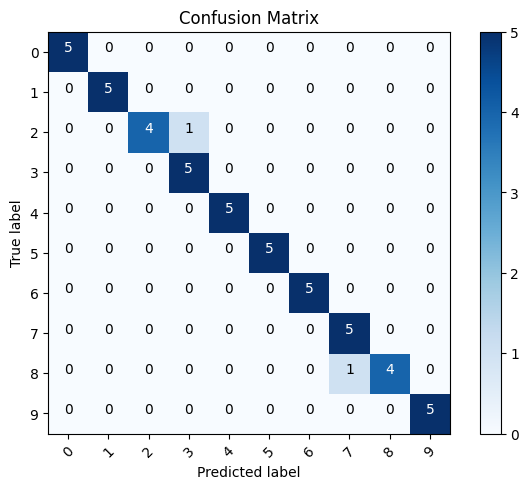

In [32]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,title='Confusion Matrix')